In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pybamm

In [2]:
model = pybamm.lithium_ion.DFN(
    options={
        "particle": "Fickian diffusion", 
        "SEI":"sei on cracks", 
        "SEI film resistance":"distributed", 
        "SEI porosity change":"true",
        "particle cracking":"negative",
        "loss of active material":"both",
        "lithium plating":"partially reversible"
    }
)

In [3]:
chemistry = pybamm.parameter_sets.Chen2020_coupled
param = pybamm.ParameterValues(chemistry=chemistry)
param.update({"Upper voltage cut-off [V]": 4.21})
param.update({"Lower voltage cut-off [V]": 2.49})
param.update({"Inner SEI reaction proportion":0})
param.update({"Initial inner SEI thickness [m]":0})
param.update({"Initial outer SEI thickness [m]": 5e-9})
param.update({"Ratio of inner and outer SEI exchange current densities": 0 })
# param.update({"Negative electrode cracking rate":3.9e-20})
# param.update({"Outer SEI solvent diffusivity [m2.s-1]": 2.5e-22})
param.update({"Lithium plating kinetic rate constant [m.s-1]": 1E-9})
param.update({"SEI-plating coupling constant [s-1]": 1E-6})

In [4]:
exp = pybamm.Experiment(["Hold at 4.2V until C/100", "Rest for 4 hours (5 minute period)"])

In [5]:
sim1 = pybamm.Simulation(
    model, 
    experiment=exp,
    parameter_values=param,
    solver=pybamm.CasadiSolver(),
)
solution1 = sim1.solve()

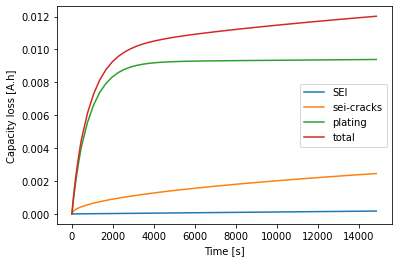

In [19]:
t = solution1["Time [s]"].entries
Qsei = solution1["Loss of lithium to negative electrode SEI [mol]"].entries
Qsei_cr = solution1["Loss of lithium to negative electrode sei-cracks [mol]"].entries
Qpl = solution1["Loss of lithium to negative electrode lithium plating [mol]"].entries
fig, ax = plt.subplots()
ax.plot(t,Qsei*96485/3600,label='SEI')
ax.plot(t,Qsei_cr*96485/3600,label='sei-cracks')
ax.plot(t,Qpl*96485/3600,label='plating')
ax.plot(t,(Qsei+Qsei_cr+Qpl)*96485/3600,label='total')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Capacity loss [A.h]")
ax.legend()
plt.show()

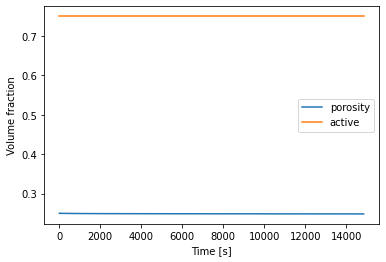

In [14]:
epsl = solution1["X-averaged negative electrode porosity"].entries
epss = solution1["X-averaged negative electrode active material volume fraction"].entries
fig, ax = plt.subplots()
ax.plot(t,epsl,label='porosity')
ax.plot(t,epss,label='active')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Volume fraction")
ax.legend()
plt.show()

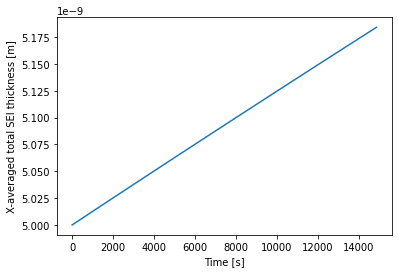

In [21]:
Lsei_sep = solution1["X-averaged total negative electrode SEI thickness [m]"].entries
fig, ax = plt.subplots()
ax.plot(t,Lsei_sep)
ax.set_xlabel("Time [s]")
ax.set_ylabel("X-averaged total SEI thickness [m]")
plt.show()

In [17]:
A = 0.1027 * 8.52E-5 * 2.25 / 5.86E-6
R = 5.0E6 * 5.2E-9 / A
dV = 2.5 * R
dxdV = (0.0349990174231383 - 0.0312962309919435) / (0.995937940000000 - 1.08288070000000)
dQ = dxdV * dV * 33133 * 0.75 * 0.1027 * 8.52E-5 * 96487 / 3600
print(dQ)

-0.004801887951646468
